In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
model_dir = '/homes/okz21/NNC/models/'
import models
from utils import test_accuracy, train_epoch, show_weights, model_prune, print_dims, get_kd_targets, get_weight_penalty
import copy

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.rcParams['text.color'] = 'white'

#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

num_epochs = 100
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_full = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [114]:
model = models.LeNet_300_100()
print_dims(model)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)

model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

300x784 + 300
100x300 + 100
10x100 + 10
Epoch: 1. Loss: 1.6045422554. Accuracy: 89.69
Epoch: 2. Loss: 1.54928636551. Accuracy: 91.34
Epoch: 3. Loss: 1.56705200672. Accuracy: 91.69
Epoch: 4. Loss: 1.53669130802. Accuracy: 92.48
Epoch: 5. Loss: 1.54481327534. Accuracy: 92.92
Epoch: 6. Loss: 1.56269919872. Accuracy: 93.19
Epoch: 7. Loss: 1.51026690006. Accuracy: 93.47
Epoch: 8. Loss: 1.54641211033. Accuracy: 93.8
Epoch: 9. Loss: 1.50025379658. Accuracy: 93.89
Epoch: 10. Loss: 1.5371850729. Accuracy: 94.02
Epoch: 11. Loss: 1.48811113834. Accuracy: 94.16
Epoch: 12. Loss: 1.53126478195. Accuracy: 94.45
Epoch: 13. Loss: 1.5327385664. Accuracy: 94.58
Epoch: 14. Loss: 1.48941671848. Accuracy: 94.73
Epoch: 15. Loss: 1.49921619892. Accuracy: 94.93
Epoch: 16. Loss: 1.53639376163. Accuracy: 94.99
Epoch: 17. Loss: 1.51585280895. Accuracy: 95.18
Epoch: 18. Loss: 1.50930738449. Accuracy: 95.4
Epoch: 19. Loss: 1.496129632. Accuracy: 95.44
Epoch: 20. Loss: 1.50793588161. Accuracy: 95.63
Epoch: 21. Loss:

### 2. Re-train Model

/homes/okz21/.conda/envs/aml/lib/python2.7/site-packages/torch/serialization.py:284: SourceChangeWarning: source code of class 'models.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


(97.65, 1.4850785732269287)
(97.76, 1.4923244714736938)


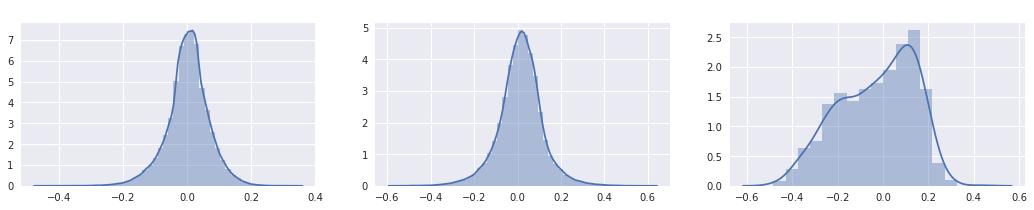

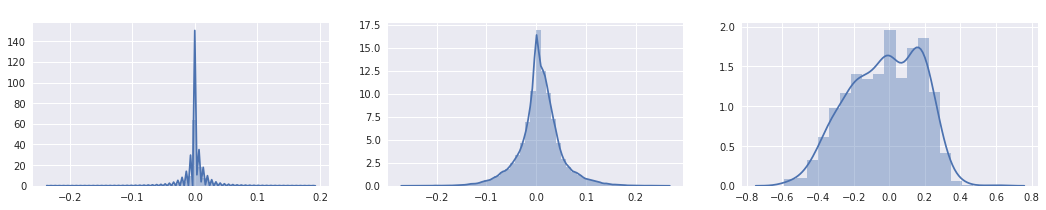

In [2]:
#Load and Show model
model_name = 'LeNet_300_100'
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, num_epochs)).cuda()
model_wd = torch.load(model_dir + 'mnist_{}_{}_wd.m'.format(model_name, num_epochs)).cuda()

print test_accuracy(test_loader, model, get_loss = True)
print test_accuracy(test_loader, model_wd, get_loss = True)

show_weights(model)
show_weights(model_wd)

Epoch: 1. Train CE Loss: 1.493, Train Accuracy: 98.958, Test CE Loss: 1.504, Test Accuracy: 97.520, Model L2: 28.723
Epoch: 2. Train CE Loss: 1.524, Train Accuracy: 98.392, Test CE Loss: 1.527, Test Accuracy: 97.510, Model L2: 21.062
Epoch: 3. Train CE Loss: 1.533, Train Accuracy: 98.072, Test CE Loss: 1.535, Test Accuracy: 97.280, Model L2: 19.099


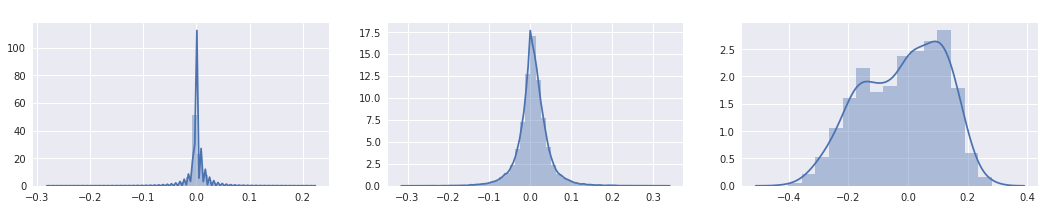

In [14]:
#Get KD Targets   
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs)).cuda()
temp = 3
train_kd_dataset = get_kd_targets(train_dataset, model, temp)
train_kd_loader = torch.utils.data.DataLoader(dataset=train_kd_dataset, batch_size=batch_size, shuffle=True)

#Load model
model_kd = models.LeNet_300_100().cuda()
model_kd.load_state_dict(model.state_dict())

#Set up Optimisers and loss
criterion_kd = nn.MSELoss()
learning_rate_kd = 0.0005
wd_kd = 0.0001
optimizer_kd_1 = torch.optim.Adam(model_kd.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_2 = torch.optim.Adam(model_kd.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_3 = torch.optim.Adam(model_kd.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

retraining_epochs=3
for epoch in range(retraining_epochs):
    model_kd, loss = train_epoch(model_kd, optimizer_kd_3, criterion_kd, train_kd_loader)
    model_kd, loss = train_epoch(model_kd, optimizer_kd_2, criterion_kd, train_kd_loader)
    model_kd, loss = train_epoch(model_kd, optimizer_kd_1, criterion_kd, train_kd_loader)
    test_acc = test_accuracy(test_loader, model_kd, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_kd, get_loss=True)
    weight_penalty = get_weight_penalty(model_kd)
    print('Epoch: {}. Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}'.format(epoch+1, train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty))
show_weights(model_kd)

In [122]:
torch.save(model_kd, model_dir + 'mnist_{}_{}.m'.format(model_kd.name, retraining_epochs))

### 3. Prune Model

In [4]:
model_kd = torch.load(model_dir + 'mnist_LeNet_300_100_kd_100.m')
model_c = models.LeNet_300_100().cuda()
pruner = model_prune(model_kd.state_dict())
deviation_list = [x/10.0 for x in range(0,21)]
percentile_list = range(0,101,5)

In [5]:
for lim in deviation_list:
    model_c.load_state_dict(pruner.deviation_prune(lim))
    test_acc = test_accuracy(test_loader, model_c, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, get_loss=True)
    weight_penalty = get_weight_penalty(model_c)
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))

TypeError: forward() takes exactly 2 arguments (3 given)

In [ ]:
for lim in percentile_list:
    model_c.load_state_dict(pruner.percentile_prune(lim))
    test_acc = test_accuracy(test_loader, model_c, kd=True, get_loss=True)
    train_acc = test_accuracy(train_loader_full, model_c, kd=True, get_loss=True)
    weight_penalty = get_weight_penalty(model_kd)
    print('Train CE Loss: {:.3f}, Train Accuracy: {:.3f}, Test CE Loss: {:.3f}, Test Accuracy: {:.3f}, Model L2: {:.3f}, Parameters Pruned: {}/{} - {:.3f}%'
          .format(train_acc[1], train_acc[0], test_acc[1], test_acc[0], weight_penalty, pruner.num_pruned, pruner.total_weights, 100.0 * pruner.num_pruned/pruner.total_weights))